In [8]:
#%%
from ngsolve import *
import ngsolve as ngs
from netgen.meshing import *
import numpy as np
import scipy.io

#%% Geometry
nnodes = 10
part = [-20, -10, 0, 0.5, 1, 11, 21]

n = []
for i in range(len(part) - 1):
    n.append(nnodes)

unit_cell = Mesh(dim = 1)

diff = 0
nodes = np.empty(0)
for i in range(len(n)):
    a = np.linspace(part[i] + diff, part[i + 1], n[i])
    nodes = np.append(nodes, a)
    diff = np.abs(nodes[len(nodes) - 1] - nodes[len(nodes) - 2])
# nodes = np.delete(nodes, 0)

pnums = []
print (nodes)
for i in range(sum(n)):
    pnums.append(unit_cell.Add(MeshPoint(Pnt(nodes[i], 0, 0))))

idx1 = unit_cell.AddRegion("pml", dim=1)
idx2 = unit_cell.AddRegion("hom", dim=1)
idx3 = unit_cell.AddRegion("rt1", dim=1)
idx4 = unit_cell.AddRegion("rt2", dim=1)

for i in range(len(nodes)-1):
    if nodes[i] <= part[1]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx1))
    elif nodes[i] > part[1] and nodes[i] <= part[2]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx2))
    elif nodes[i] > part[2] and nodes[i] <= part[3]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx3))
    elif nodes[i] > part[3] and nodes[i] <= part[4]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx4))
    elif nodes[i] > part[4] and nodes[i] <= part[5]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx2))
    elif nodes[i] > part[5] and nodes[i] <= part[6]:
        unit_cell.Add (Element1D([pnums[i], pnums[i+1]], index = idx1))

id5 = unit_cell.AddRegion("l", dim=0)
id6 = unit_cell.AddRegion("r", dim=0)

unit_cell.Add (Element0D(pnums[0] , index=id5))
unit_cell.Add (Element0D(pnums[-1], index=id6))

[-20.         -18.88888889 -17.77777778 -16.66666667 -15.55555556
 -14.44444444 -13.33333333 -12.22222222 -11.11111111 -10.
  -8.88888889  -7.90123457  -6.91358025  -5.92592593  -4.9382716
  -3.95061728  -2.96296296  -1.97530864  -0.98765432   0.
   0.98765432   0.93347051   0.87928669   0.82510288   0.77091907
   0.71673525   0.66255144   0.60836763   0.55418381   0.5
   0.55418381   0.60371895   0.65325408   0.70278921   0.75232434
   0.80185947   0.8513946    0.90092974   0.95046487   1.
   1.04953513   2.15514234   3.26074955   4.36635675   5.47196396
   6.57757117   7.68317838   8.78878558   9.89439279  11.
  12.10560721  13.09387307  14.08213894  15.07040481  16.05867067
  17.04693654  18.0352024   19.02346827  20.01173413  21.        ]


1

In [2]:
#%% Meshing
mesh = ngs.Mesh(unit_cell)
mesh.SetPML(pml.Cartesian(mins = -10, alpha=1j, maxs = 11), 'pml')


In [3]:

#%% Materials

rhd = {'pml' : 1, 'hom' : 1, 'rt1' : 1, 'rt2' : 1}
mud = {'pml' : 2, 'hom' : 2, 'rt1' : 2, 'rt2' : 2}

rho = CoefficientFunction([rhd[mat] for mat in mesh.GetMaterials()])
mu  = CoefficientFunction([mud[mat] for mat in mesh.GetMaterials()])

#%% Solution
omega = 2

fes = H1(mesh, order=10, complex=True)
u = fes.TrialFunction()
v = fes.TestFunction()

b = (10**2 / np.pi) * exp(-50**2*((x+7)**2))
    
a = BilinearForm(fes)
a += mu*grad(u)*grad(v)*dx - omega**2*rho*u*v*dx
    
f = LinearForm(fes)
f += b*v*dx # + t*v*ds("dir_neu")
    
a.Assemble()
f.Assemble()
    
gfu = GridFunction(fes)
    
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

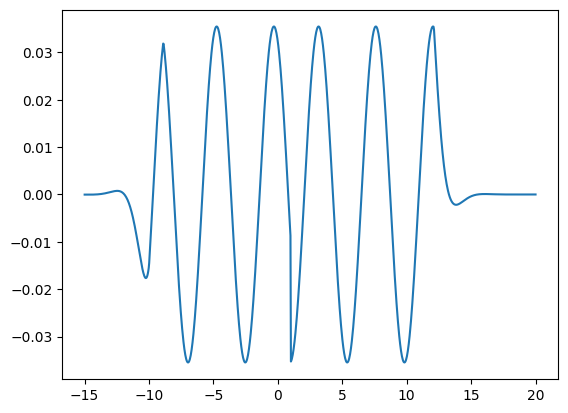

In [10]:

# %% postprocessing
x = np.linspace(-15, 20, 1000)
u = gfu(mesh(x))

import matplotlib.pyplot as plt
plt.plot(x, np.imag(u))
plt.show()